# Libraries

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
from random import randint
import math
import re

'''Data Viz'''
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import matplotlib.cm as cm
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import joblib 

'''Algos'''
#import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

from osgeo import gdal
from osgeo import gdal_array
import matplotlib.pyplot as plt
import numpy as np
import sys
from osgeo.gdalconst import *
import os

import math
import codecs

import osgeo #this is necessary for the type comparison in some methods
from osgeo import osr
from osgeo import ogr
from collections import defaultdict
import itertools
from osgeo import gdal_array as gdar
from osgeo import gdalconst as gdct
import glob

# Inputs

In [2]:
path_images = '/Users/clara/Projects/A4_Cube/Images/Strobler/'
bands = ['Cloud','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
model_filepath = '/Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Models/'
figures_filepath = '/Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Figures/'

# Without scaling

# Data from .tif images

**UPLOAD TIFF AND CUSTOMIZE ARRAY**

In [3]:
def is_leap_year(year):
    """ if year is a leap year return True
        else return False """
    if year % 100 == 0:
        return year % 400 == 0
    return year % 4 == 0

def doy(Y,M,D):
    """ given year, month, day return day of year
        Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7 """
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    N = int((275 * M) / 9.0) - K * int((M + 9) / 12.0) + D - 30
    return N

In [4]:
#Train
trainArray = []
ymds = []
doys = []

files = sorted(os.listdir(path_images))
for f in files:
    if not f.startswith(('.', 'm')) and f.endswith(('.tif')) and os.path.isfile(os.path.join(path_images, f)):
        # Bands
        tif = gdal_array.LoadFile(path_images+f)
        tif = np.delete(tif, 0, axis=0)
        tif = np.delete(tif, 10, axis=0)
        tif = tif/6000
        
        # DOY: t1, t2
        Y_M_D = re.sub("[^0-9]", "", f)
        ymds.append(Y_M_D)
        d = doy(int(Y_M_D[-4:]),int(Y_M_D[2:4]),int(Y_M_D[:2]))
        doys.append(d)
        t1 = np.full((tif.shape[1], tif.shape[2]), (np.sin(d*2*np.pi/365)+1)/2)
        t2 = np.full((tif.shape[1], tif.shape[2]), (np.cos(d*2*np.pi/365)+1)/2)
        t1_t2 = np.stack([t1, t2], axis=0)
        
        # Join
        tif = np.concatenate([tif, t1_t2], axis=0)
        print(tif.shape)
        trainArray.append(tif)

trainArray = np.stack(trainArray, axis = 0)

print(f'''-> Files:
{files}''')
print(f'-> Dates: {ymds}')
print(f'-> DOYs: {doys}')
print(f'-> tifArray shape: {trainArray.shape}')

(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
-> Files:
['.DS_Store', 'Strobbler_clean_Image_01042017.tif', 'Strobbler_clean_Image_01042017.tif.aux.xml', 'Strobbler_clean_Image_02082017.tif', 'Strobbler_clean_Image_02082017.tif.aux.xml', 'Strobbler_clean_Image_04082018.tif', 'Strobbler_clean_Image_04082018.tif.aux.xml', 'Strobbler_clean_Image_05072017.ti

In [5]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 't1', 't2']

# Image selection

In [6]:
# Delete images
img_cloud = [4, 12, 17, 19, 22, 30, 34, 36, 42]
trainArray = np.delete(trainArray, img_cloud, axis=0)
shape=trainArray.shape
print(f'shape: {shape}')

shape: (37, 14, 193, 354)


In [7]:
doys = list(np.delete(np.array(doys), img_cloud, axis = 0))
ymds = list(np.delete(np.array(ymds), img_cloud, axis = 0))
len(doys)

37

# True color composite

In [8]:
'''# Fill in number of figures:
n_figures = trainArray.shape[0]

# Prepare subplots
n_rows = int(math.ceil((n_figures)**(1/2)))
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'True Color Composite', fontsize = 50)

# Plot images
for sp in range(n_figures):
    image = trainArray[sp]
    img = np.dstack((image[3, ...]*4, image[2, ...]*4, image[1, ...]*4))
    img = np.clip(img, 0, 1)
    ax = axs[rows[sp], columns[sp]]
    img = ax.imshow(np.array(img))
    ax.grid(color='black', linewidth=0.3)
    ax.set_title(f'Image DOY: {doys[sp]} and Date: {ymds[sp]}', fontsize=20)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

# save
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(f'{figures_filepath}/original_images.png', format='png', dpi=300)
plt.show()'''

"# Fill in number of figures:\nn_figures = trainArray.shape[0]\n\n# Prepare subplots\nn_rows = int(math.ceil((n_figures)**(1/2)))\nn_cols = int(math.ceil(n_figures/n_rows))\nrows=[]\ncolumns = []\nfor row in range(n_rows):\n    for col in range(n_cols):\n        rows.append(row)\n        columns.append(col)\n\n# Subplots and figure title\nfig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))\nfig.suptitle(f'True Color Composite', fontsize = 50)\n\n# Plot images\nfor sp in range(n_figures):\n    image = trainArray[sp]\n    img = np.dstack((image[3, ...]*4, image[2, ...]*4, image[1, ...]*4))\n    img = np.clip(img, 0, 1)\n    ax = axs[rows[sp], columns[sp]]\n    img = ax.imshow(np.array(img))\n    ax.grid(color='black', linewidth=0.3)\n    ax.set_title(f'Image DOY: {doys[sp]} and Date: {ymds[sp]}', fontsize=20)\n\n# delete empty figures\nfor image in range(n_figures, n_rows*n_cols):\n    axs[rows[image], columns[image]].set_axis_off()\n\n# save\nplt.tight_layout()\nfig.subplots_adjus

# Plot reflectances depending on the landcover

- **Select the pixel**

In [9]:
landcover = 'Cluster4-Strobbler_Scaled'
x = 65
y = 46

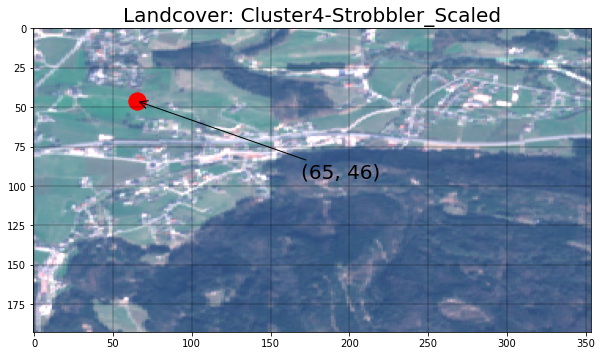

In [10]:
plt.figure(figsize=(10,10))
image = trainArray[0]
img = np.dstack((image[3, ...]*4, image[2, ...]*4, image[1, ...]*4))
img = np.clip(img, 0, 1)
plt.imshow(np.array(img))
plt.annotate(f'({x}, {y})', xy=(x, y), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.scatter(x, y, s=300, c='red', marker='o')
plt.grid(color='black', linewidth=0.3)
plt.title(f'Landcover: {landcover}', fontsize=20)
plt.savefig(f'{figures_filepath}/{landcover}_point.png', format='png', dpi=300)

In [11]:
pixel = trainArray[:,:,y,x]
pixel.shape

(37, 14)

- **Plot pixel reflectances**

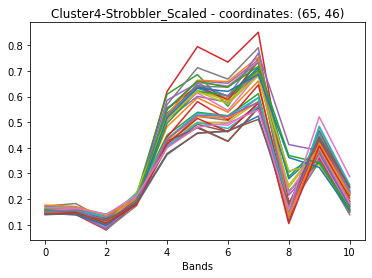

In [12]:
plt.plot(np.transpose(pixel[:,1:-2]));
plt.xlabel('Bands')
plt.title(f'{landcover} - coordinates: ({x}, {y})')
plt.savefig(f'{figures_filepath}/{landcover}_reflectances.png', format='png', dpi=300)

# Plot pixel reflectances along time

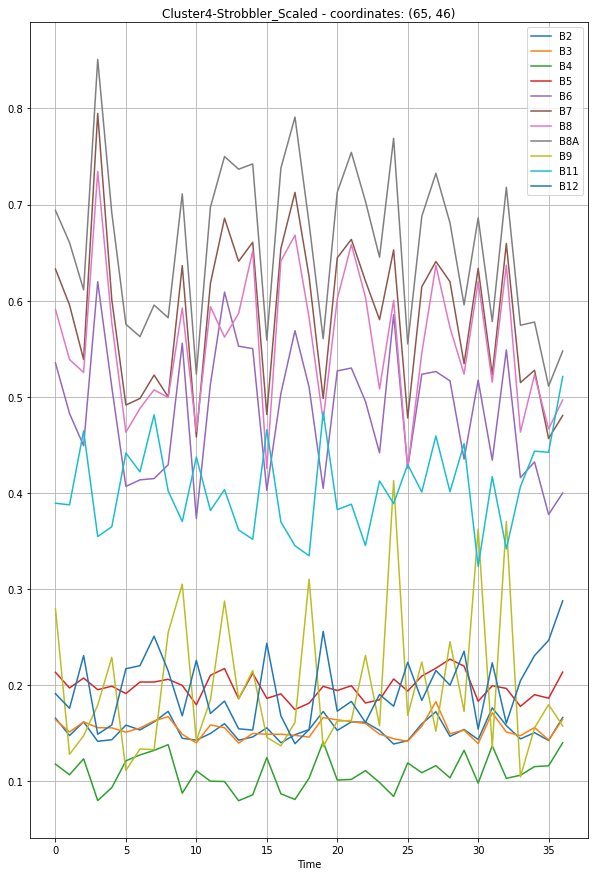

In [13]:
plt.figure(figsize=(10,15))
plt.plot(pixel[:,1:-2]);
plt.xlabel('Time')
plt.title(f'{landcover} - coordinates: ({x}, {y})')
plt.grid()
plt.legend(bands[1:-2])
plt.savefig(f'{figures_filepath}/{landcover}_reflectances.png', format='png', dpi=300)

# Autoencoder

Preparing training data...
Training the model...
Epoch 00093: early stopping
Min error: 0.0026639187708497047
INFO:tensorflow:Assets written to: /Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Models/assets


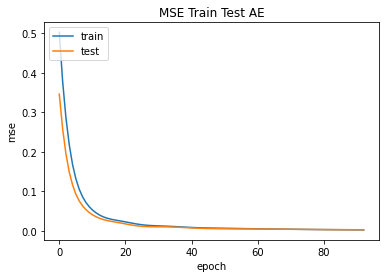

Epoch 00079: early stopping
Min error: 0.0017648624489083886
INFO:tensorflow:Assets written to: /Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Models/assets


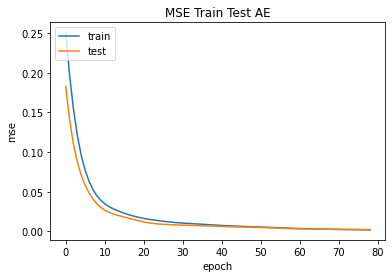

Epoch 00088: early stopping
Min error: 0.001595845795236528
INFO:tensorflow:Assets written to: /Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Models/assets


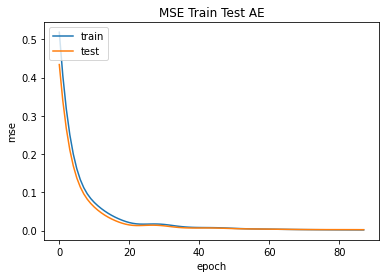

Epoch 00099: early stopping
Min error: 0.0018286551348865032
Epoch 00069: early stopping
Min error: 0.0019091235008090734
Epoch 00075: early stopping
Min error: 0.0017215488478541374
Running time AEs --- minutes ----0.5074078520139058


In [14]:
# early stopping
es = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', min_delta = 0.001, verbose = 2, patience = 12) 

start = time.time()

lowest_error = 100000000

## Create a folder for the AE
# Model filepaths
mf = model_filepath

# Figures filepaths
mf2 = os.path.join(figures_filepath, 'Training')
if not os.path.exists(mf2):
      os.mkdir(mf2)
mf3 = os.path.join(figures_filepath, 'Error')
if not os.path.exists(mf3):
      os.mkdir(mf3)
mf4 = os.path.join(figures_filepath, 'Reflectance')
if not os.path.exists(mf4):
      os.mkdir(mf4)


## Prepare training data
print('Preparing training data...')


# Data of the selected pixels
data = pixel


## Train AE
print('Training the model...')
for n in range(6):
    # Create model
    model = Sequential()

    # Create layers
    model.add(Dense(units=10, activation='linear', input_dim=len(bands)))
    model.add(Dense(units=len(bands), activation='linear'))

    # Compile model (a traditional default value for the learning rate is 0.1 or 0.01)
    opt = keras.optimizers.Adam(learning_rate=0.01)
    tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    model.compile(optimizer=opt, loss="mean_squared_error", metrics=['mse'])

    # Train
    X_train, X_test = train_test_split(data, test_size=0.2, random_state=1)
    history = model.fit(x=X_train, y=X_train,
                        epochs=200,
                        batch_size= None,
                        shuffle=True,
                        validation_data=(X_test,X_test),
                        verbose=0,
                        callbacks=[es])

    # Save best model
    error = min(history.history['mse'])
    print(f'Min error: {error}')

    if error < lowest_error:
        lowest_error = error
        model.save(mf, overwrite=True, include_optimizer=True)
        # Plot train-test curves
        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title(f'MSE Train Test AE')
        plt.ylabel('mse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(f'{mf2}/traintestCurvesAE.png', format='png', dpi=300)
        plt.show()
    pass

end = time.time()

print(f'Running time AEs --- minutes ----{(end-start)/60}')

# Prediction

In [15]:
mf = model_filepath

# Upload best model
model = keras.models.load_model(mf)

## Prediction
print(f'Predicting autoencoder...')
start_p = time.time()
TRAINpredicted = model.predict(x=pixel, verbose=1)

end_p = time.time()
print(f'Prediction time AE ---minutes--- {(end_p-start_p)/60}')

Predicting autoencoder...
2/2 [==============================] - 0s 3ms/step
Prediction time AE ---minutes--- 0.002404514948527018


**SHOW PIXEL RECONSTRUCTION PER BAND**

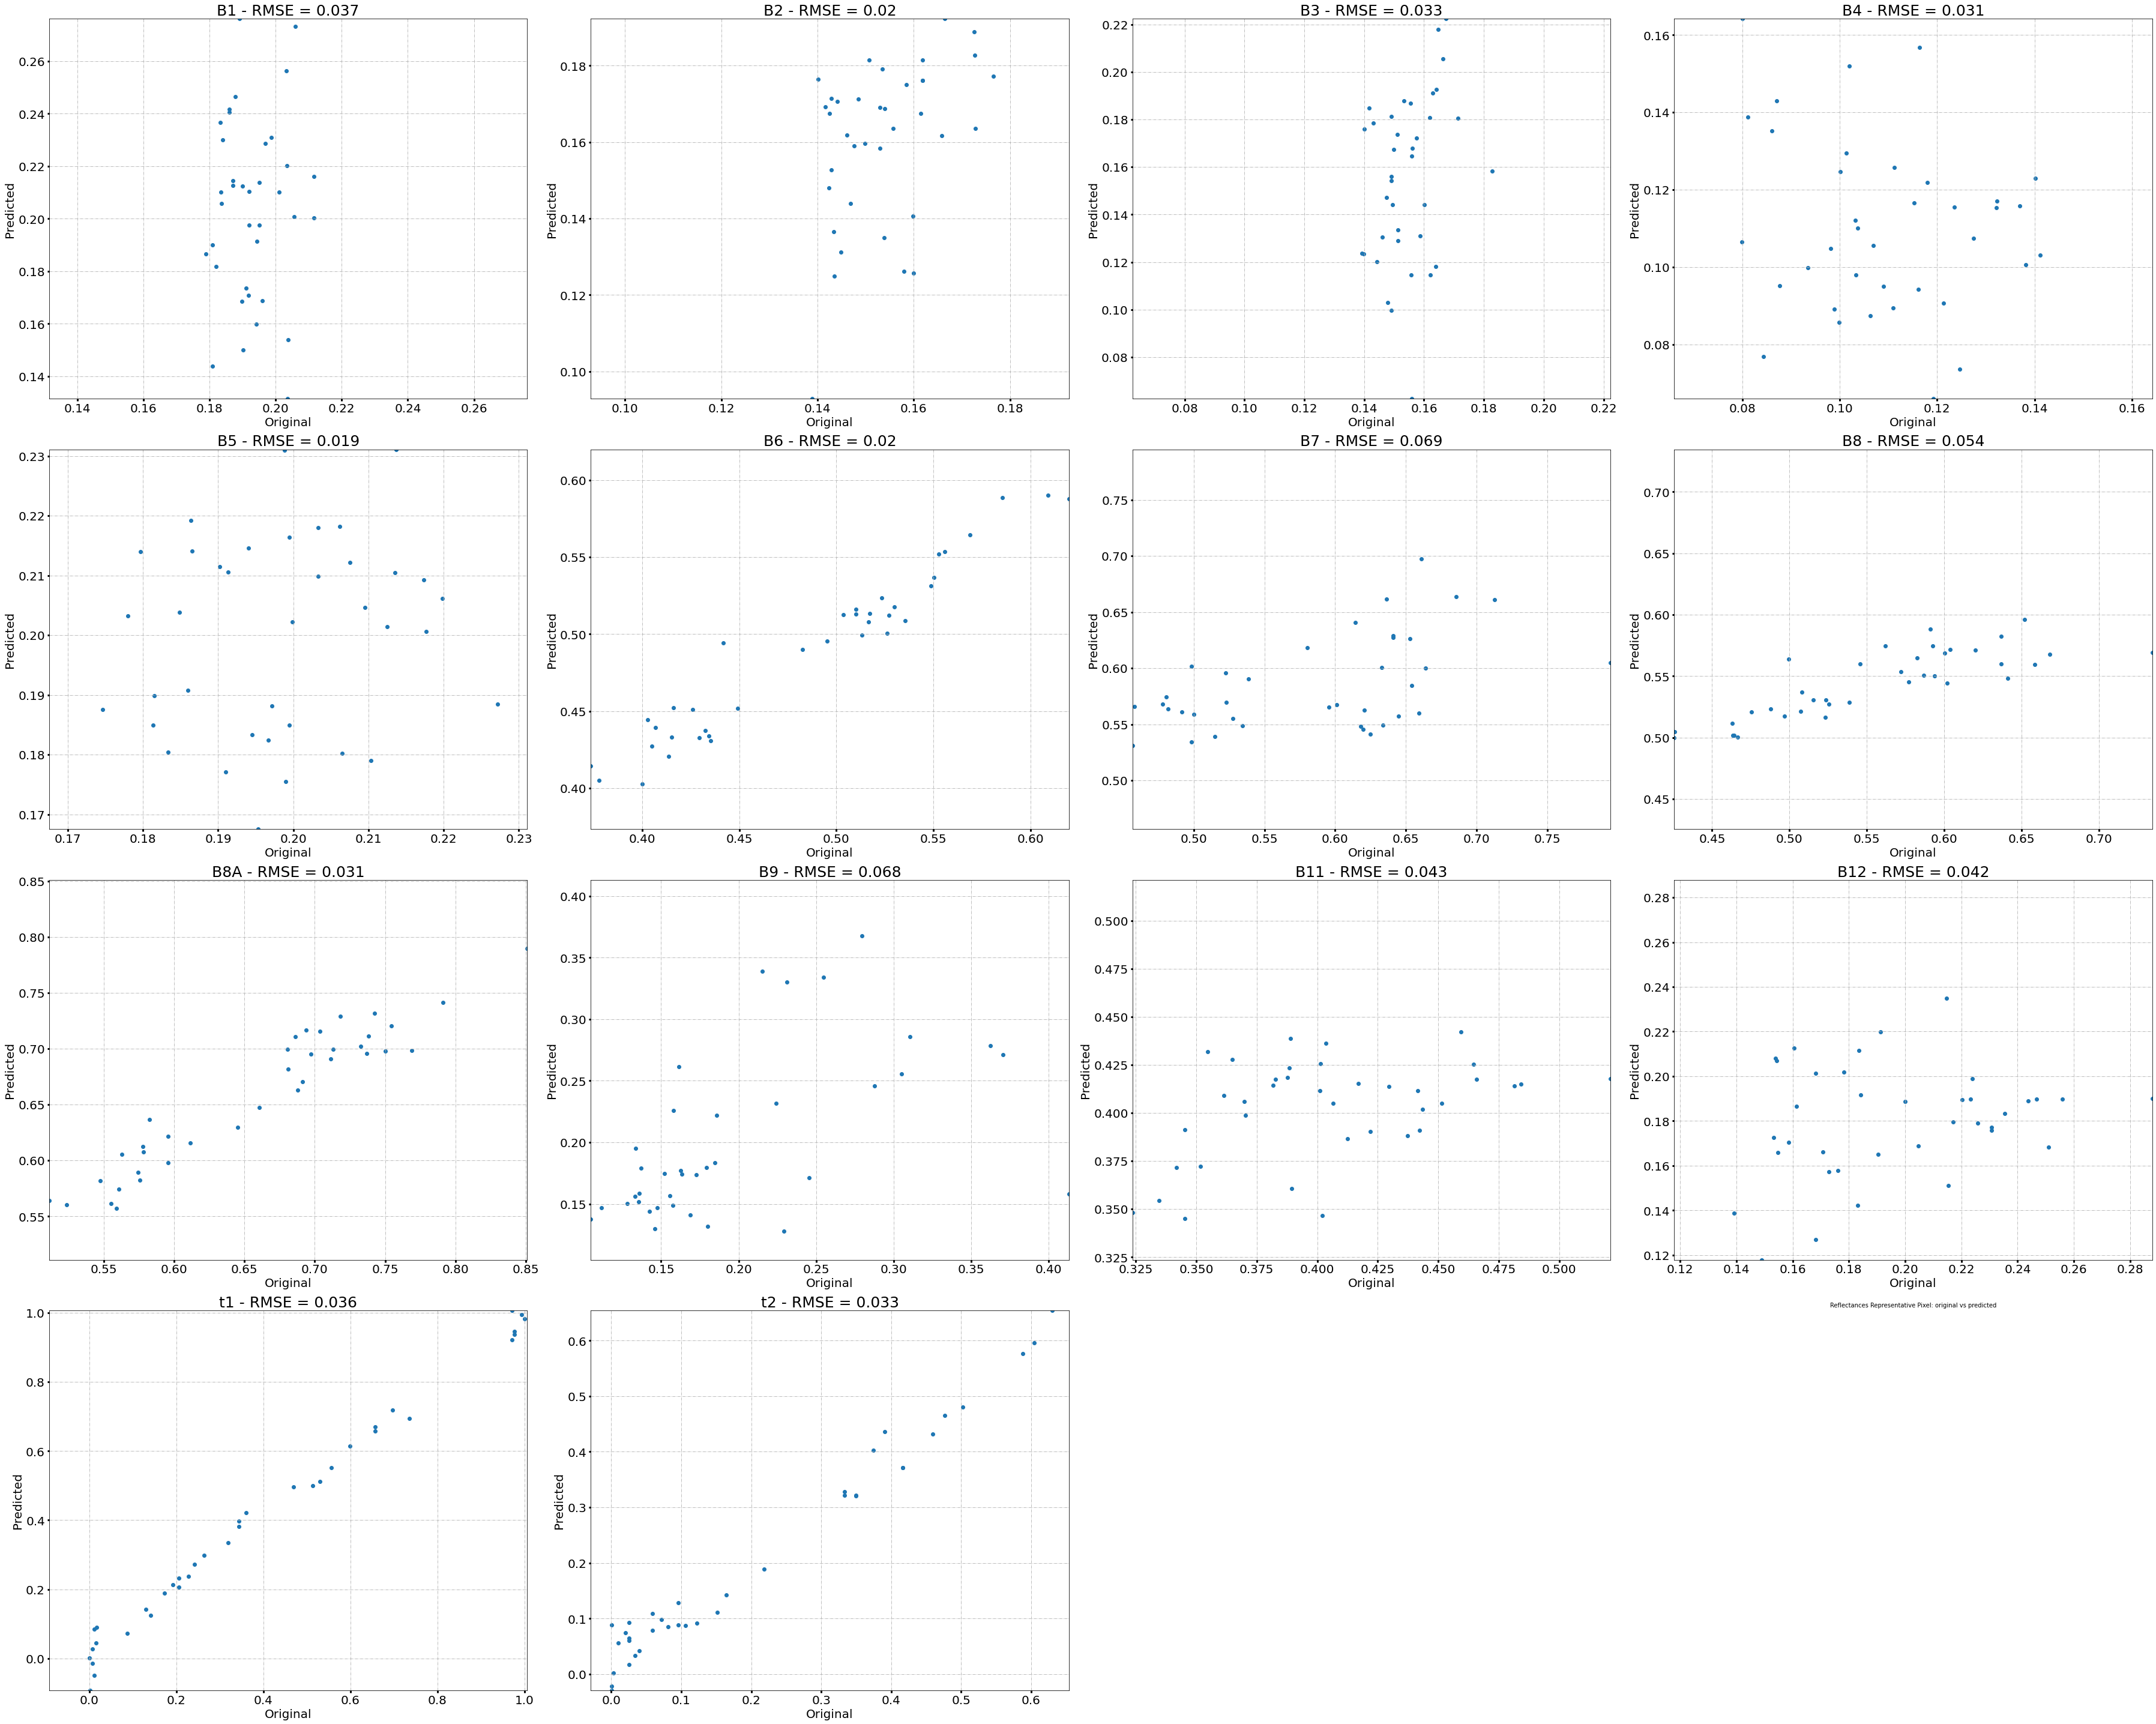

Sum RMSE all bands...
Total RMSE autoencoder: 0.536


In [16]:
from matplotlib.cbook import flatten
# Prepare subplots
n_figures = len(bands)
n_rows = int(math.ceil((n_figures)**(1/2))) #add an extra row to have space for the colorbar
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
rms_l = []

# reflectance bands: B1, B2, B3, B4, B5
for sp in range(n_figures):
    ori = pixel[:,sp]
    pre = TRAINpredicted[:,sp]
    rms = round(mean_squared_error(ori, pre, squared=False),3)
    rms_l.append(rms)
    ax = axs[rows[sp], columns[sp]]
    im = ax.scatter(ori, pre)
    ax.set_xlim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
    ax.set_ylim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
    ax.set_title(f'{bands[sp]} - RMSE = {rms}', fontsize=25)
    ax.set_xlabel('Original', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)

# delete empty figures
for sp in range(n_figures, n_rows*n_cols):
    axs[rows[sp], columns[sp]].set_axis_off()

plt.title(f'Reflectances Representative Pixel: original vs predicted', fontsize=10)
plt.tight_layout()
plt.savefig(f'{mf4}/OriginalvsReconstructed_{landcover}_x:{x}_y:{y}.png', format='png', dpi=300)
plt.show()

# print total RMSE
print('Sum RMSE all bands...')
print(f'Total RMSE autoencoder: {np.sum(np.array(rms_l))}')

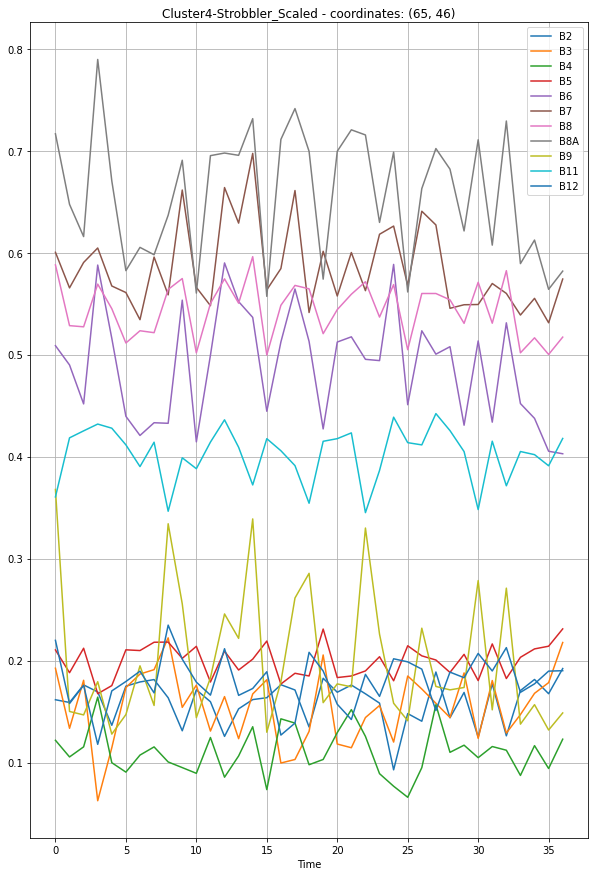

In [17]:
plt.figure(figsize=(10,15))
plt.plot(TRAINpredicted[:,1:-2]);
plt.xlabel('Time')
plt.title(f'{landcover} - coordinates: ({x}, {y})')
plt.grid()
plt.legend(bands[1:-2])
plt.savefig(f'{figures_filepath}/{landcover}_reflectancesRECONSTRUCTED.png', format='png', dpi=300)

# TRY: not dividing data and scaling

In [18]:
#Train
trainArray = []
ymds = []
doys = []

files = sorted(os.listdir(path_images))
for f in files:
    if not f.startswith(('.', 'm')) and f.endswith(('.tif')) and os.path.isfile(os.path.join(path_images, f)):
        # Bands
        tif = gdal_array.LoadFile(path_images+f)
        tif = np.delete(tif, 0, axis=0)
        tif = np.delete(tif, 10, axis=0)
        
        # DOY: t1, t2
        Y_M_D = re.sub("[^0-9]", "", f)
        ymds.append(Y_M_D)
        d = doy(int(Y_M_D[-4:]),int(Y_M_D[2:4]),int(Y_M_D[:2]))
        doys.append(d)
        t1 = np.full((tif.shape[1], tif.shape[2]), (np.sin(d*2*np.pi/365)+1)/2)
        t2 = np.full((tif.shape[1], tif.shape[2]), (np.cos(d*2*np.pi/365)+1)/2)
        t1_t2 = np.stack([t1, t2], axis=0)
        
        # Join
        tif = np.concatenate([tif, t1_t2], axis=0)
        print(tif.shape)
        trainArray.append(tif)

trainArray = np.stack(trainArray, axis = 0)

print(f'''-> Files:
{files}''')
print(f'-> Dates: {ymds}')
print(f'-> DOYs: {doys}')
print(f'-> tifArray shape: {trainArray.shape}')

(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
(14, 193, 354)
-> Files:
['.DS_Store', 'Strobbler_clean_Image_01042017.tif', 'Strobbler_clean_Image_01042017.tif.aux.xml', 'Strobbler_clean_Image_02082017.tif', 'Strobbler_clean_Image_02082017.tif.aux.xml', 'Strobbler_clean_Image_04082018.tif', 'Strobbler_clean_Image_04082018.tif.aux.xml', 'Strobbler_clean_Image_05072017.ti

**Image selection**

In [19]:
# Delete images
img_cloud = [4, 12, 17, 19, 22, 30, 34, 36, 42]
trainArray = np.delete(trainArray, img_cloud, axis=0)
shape=trainArray.shape
print(f'shape: {shape}')

shape: (37, 14, 193, 354)


In [20]:
doys = list(np.delete(np.array(doys), img_cloud, axis = 0))
ymds = list(np.delete(np.array(ymds), img_cloud, axis = 0))
len(doys)

37

**Plot pixel reflectances along time**

In [21]:
pixel = trainArray[:,:, y, x]

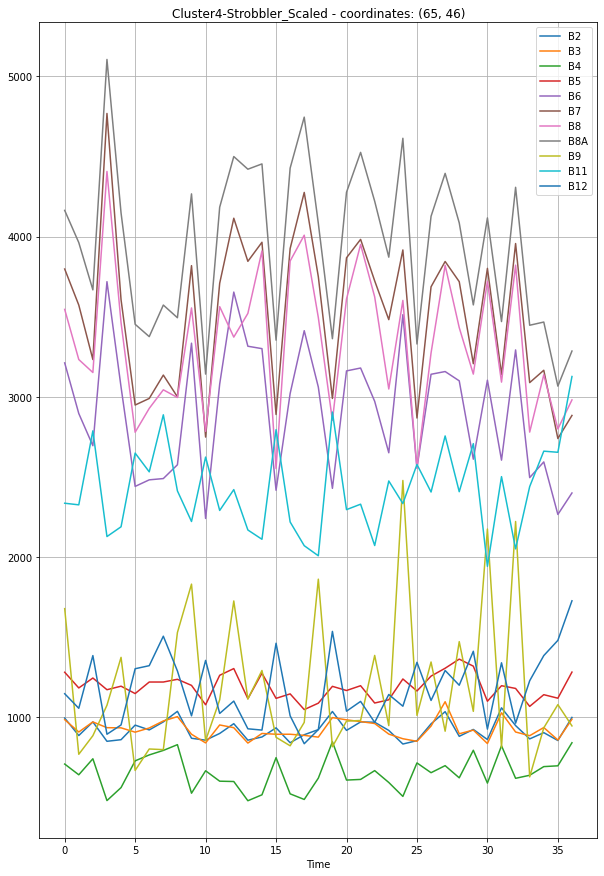

In [22]:
plt.figure(figsize=(10,15))
plt.plot(pixel[:,1:-2]);
plt.xlabel('Time')
plt.title(f'{landcover} - coordinates: ({x}, {y})')
plt.grid()
plt.legend(bands[1:-2])
plt.savefig(f'{figures_filepath}/{landcover}_reflectancesNOTDIVIDED.png', format='png', dpi=300)

**Scale data**

In [23]:
def scale_MinMax (array, model_filepath):
    
    # Create scaler and scale
    scaler = pp.MinMaxScaler()
    array_scaled = scaler.fit_transform(array)
    
    #Create new folder and save
    mf_scaler = os.path.join(model_filepath, 'Scaler')
    if not os.path.exists(mf_scaler):
        os.mkdir(mf_scaler) 
    
    joblib.dump(scaler, mf_scaler + '/scale.mod')
    
    return array_scaled

In [24]:
pixel_scaled = scale_MinMax(pixel, model_filepath)

**Autoencoder**

Preparing training data...
Training the model...
Epoch 00108: early stopping
Min error: 0.005257867742329836
INFO:tensorflow:Assets written to: /Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Models//Scaler/assets


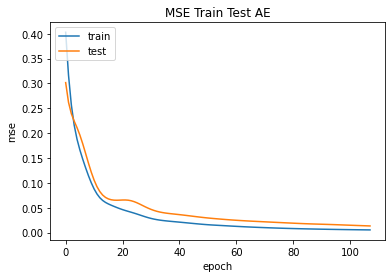

Epoch 00114: early stopping
Min error: 0.004650757648050785
INFO:tensorflow:Assets written to: /Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Models//Scaler/assets


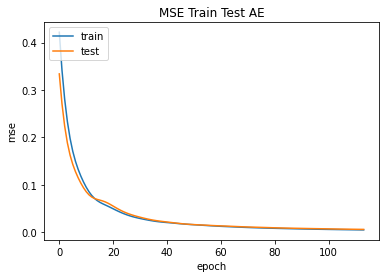

Epoch 00116: early stopping
Min error: 0.005063793621957302
Epoch 00099: early stopping
Min error: 0.00560868252068758
Epoch 00085: early stopping
Min error: 0.0040309191681444645
INFO:tensorflow:Assets written to: /Users/clara/Projects/A4_Cube/Codes/Strobler/reconstruction/Models//Scaler/assets


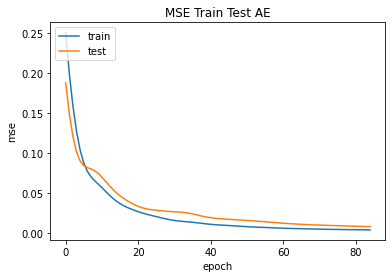

Epoch 00103: early stopping
Min error: 0.00794595293700695
Running time AEs --- minutes ----0.6036607980728149


In [25]:
# early stopping
es = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', min_delta = 0.001, verbose = 2, patience = 12) 

start = time.time()

lowest_error = 100000000

## Create a folder for the AE
# Model filepaths
mf = model_filepath + '/Scaler/'

# Figures filepaths
mf2 = os.path.join(figures_filepath, 'Training')
if not os.path.exists(mf2):
      os.mkdir(mf2)
mf3 = os.path.join(figures_filepath, 'Error')
if not os.path.exists(mf3):
      os.mkdir(mf3)
mf4 = os.path.join(figures_filepath, 'Reflectance')
if not os.path.exists(mf4):
      os.mkdir(mf4)


## Prepare training data
print('Preparing training data...')


# Data of the selected pixels
data = pixel_scaled


## Train AE
print('Training the model...')
for n in range(6):
    # Create model
    model = Sequential()

    # Create layers
    model.add(Dense(units=10, activation='linear', input_dim=len(bands)))
    model.add(Dense(units=len(bands), activation='linear'))

    # Compile model (a traditional default value for the learning rate is 0.1 or 0.01)
    opt = keras.optimizers.Adam(learning_rate=0.01)
    tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    model.compile(optimizer=opt, loss="mean_squared_error", metrics=['mse'])

    # Train
    X_train, X_test = train_test_split(data, test_size=0.2, random_state=1)
    history = model.fit(x=X_train, y=X_train,
                        epochs=200,
                        batch_size= None,
                        shuffle=True,
                        validation_data=(X_test,X_test),
                        verbose=0,
                        callbacks=[es])

    # Save best model
    error = min(history.history['mse'])
    print(f'Min error: {error}')

    if error < lowest_error:
        lowest_error = error
        model.save(mf, overwrite=True, include_optimizer=True)
        # Plot train-test curves
        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title(f'MSE Train Test AE')
        plt.ylabel('mse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(f'{mf2}/traintestCurvesAE.png', format='png', dpi=300)
        plt.show()
    pass

end = time.time()

print(f'Running time AEs --- minutes ----{(end-start)/60}')

**Prediction**

In [26]:
mf = model_filepath + '/Scaler/'
scaler = joblib.load(mf + 'scale.mod')

# Upload best model
model = keras.models.load_model(mf)

## Prediction
print(f'Predicting autoencoder...')
start_p = time.time()
TRAINpredicted_scaled = model.predict(x=pixel_scaled, verbose=1)

end_p = time.time()
print(f'Prediction time AE ---minutes--- {(end_p-start_p)/60}')

Predicting autoencoder...
2/2 [==============================] - 0s 2ms/step
Prediction time AE ---minutes--- 0.0011747161547342936


**Return to original scale**

In [27]:
TRAINpredicted = scaler.inverse_transform(TRAINpredicted_scaled)

**SHOW PIXEL RECONSTRUCTION PER BAND**

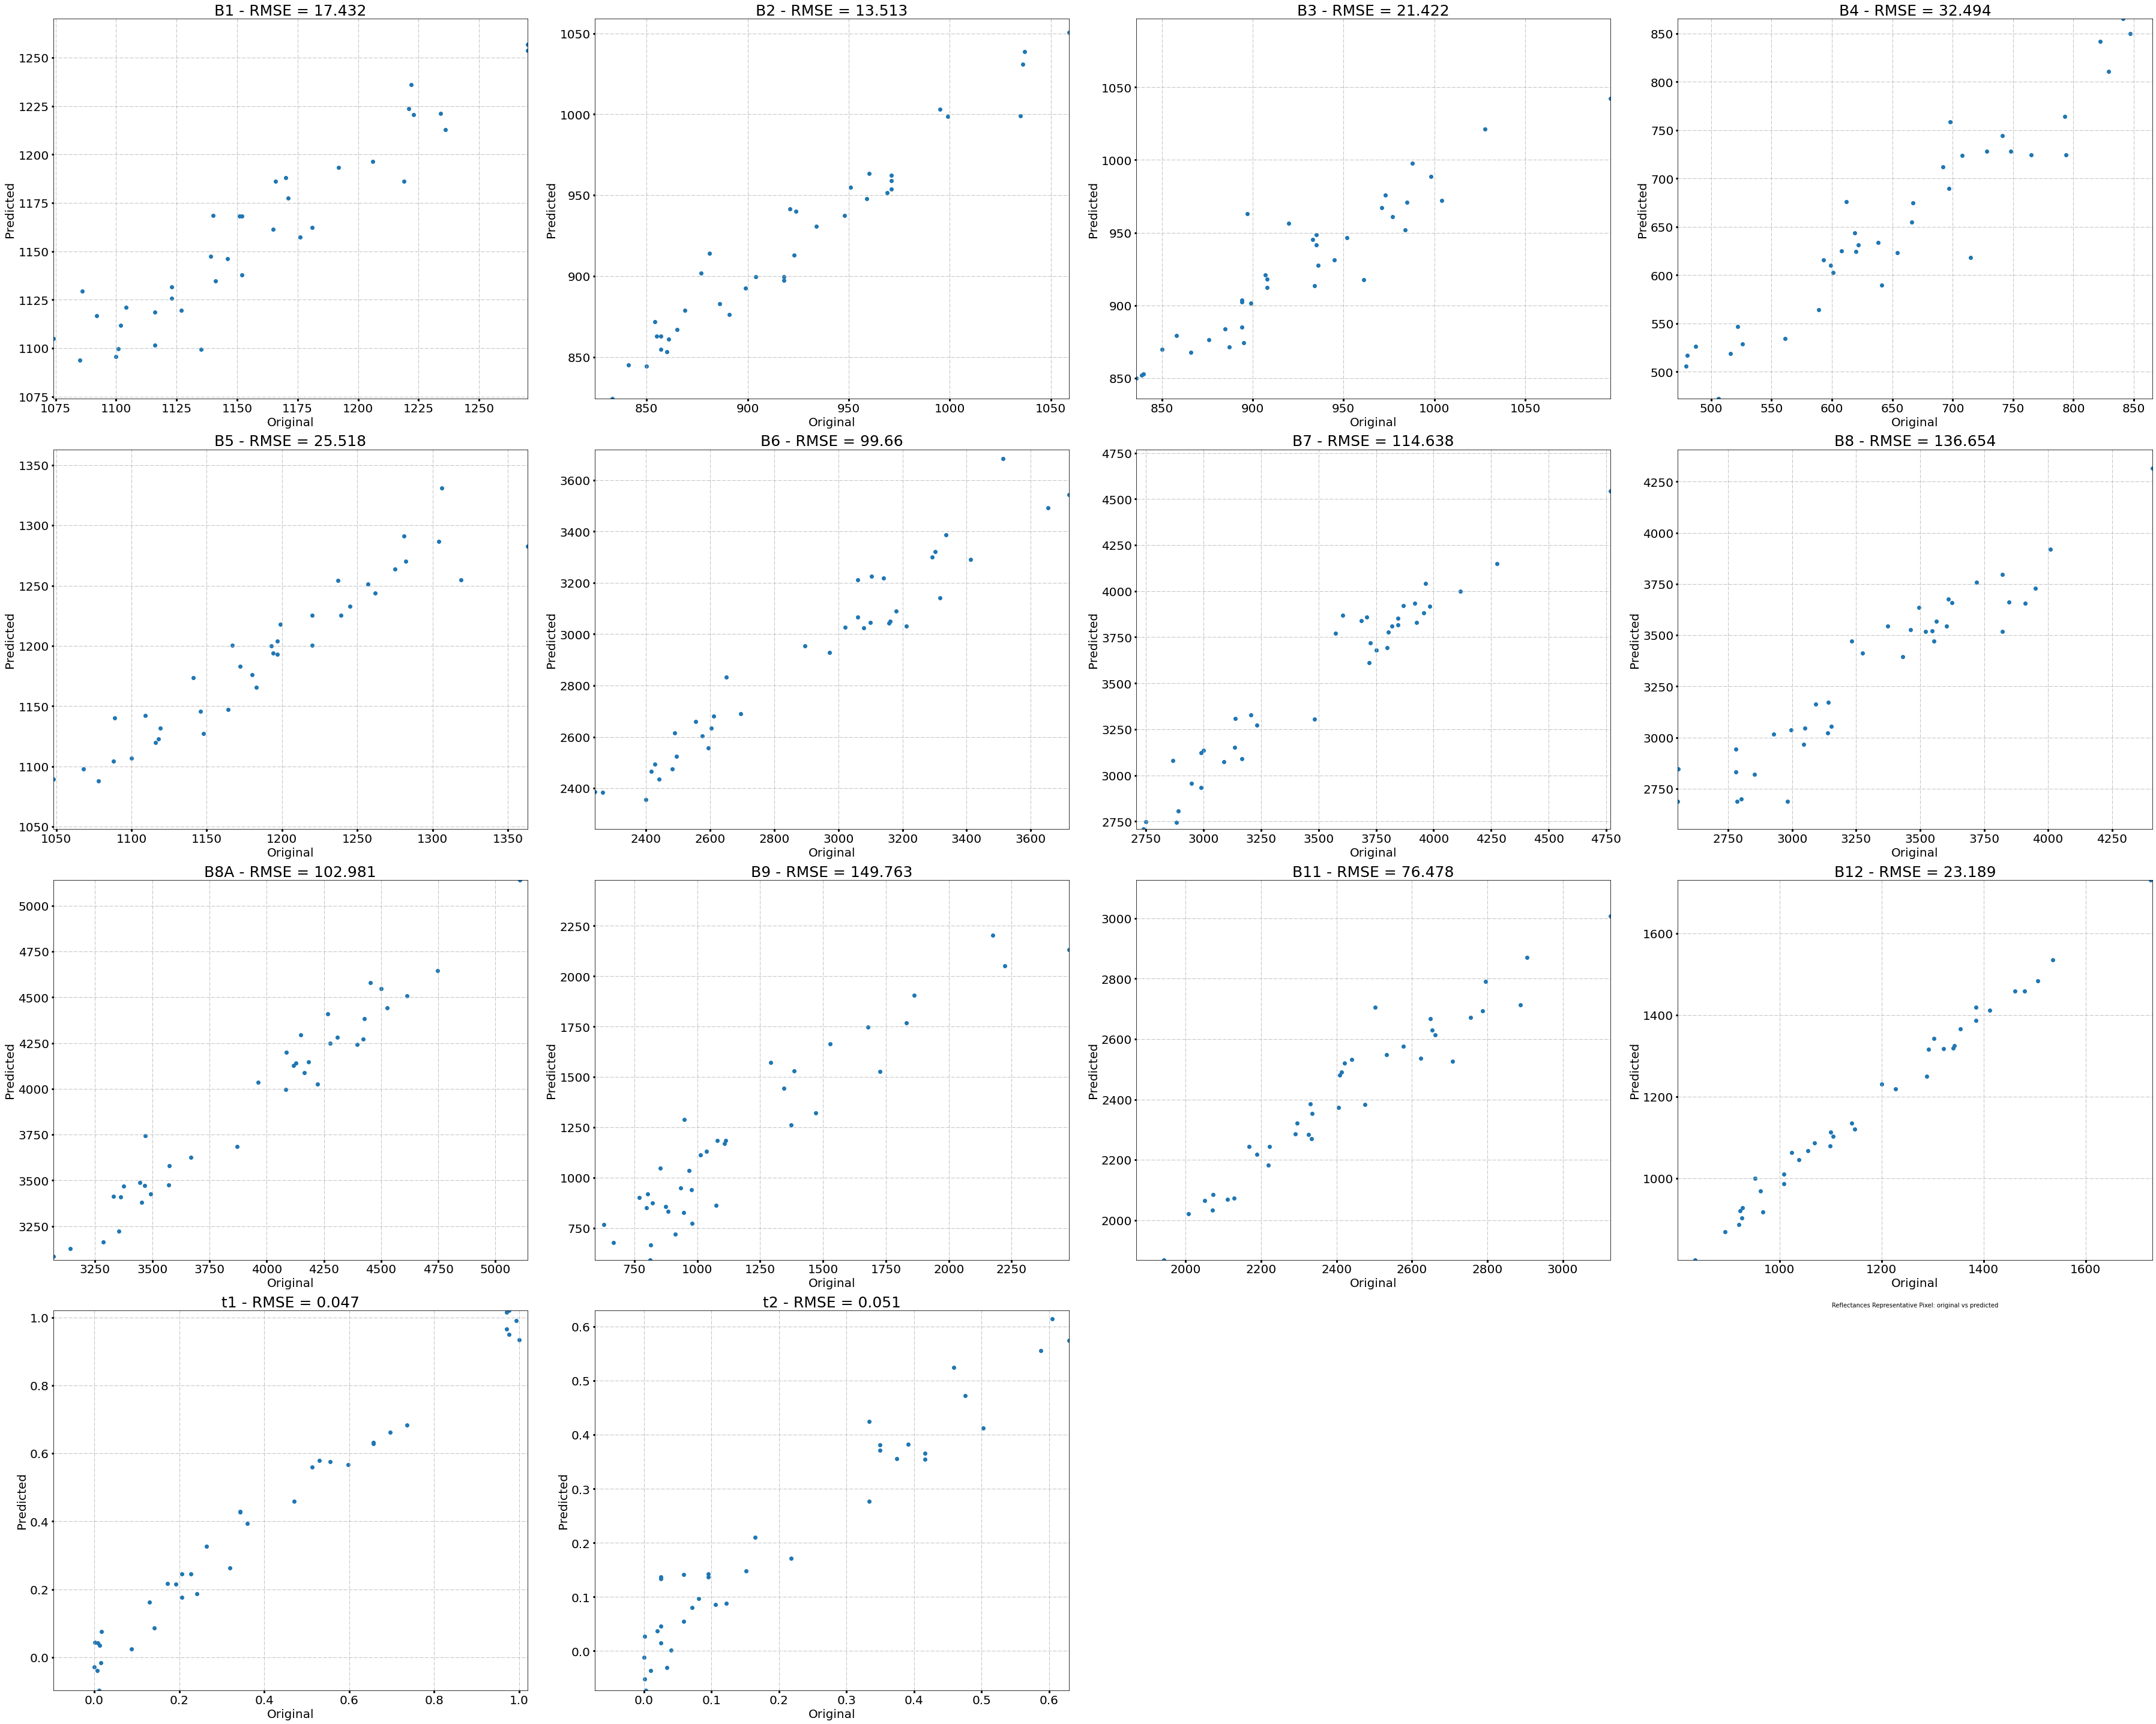

Sum RMSE all bands...
Total RMSE autoencoder: 813.84


In [28]:
from matplotlib.cbook import flatten
# Prepare subplots
n_figures = len(bands)
n_rows = int(math.ceil((n_figures)**(1/2))) #add an extra row to have space for the colorbar
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
rms_l = []

# reflectance bands: B1, B2, B3, B4, B5
for sp in range(n_figures):
    ori = pixel[:,sp]
    pre = TRAINpredicted[:,sp]
    rms = round(mean_squared_error(ori, pre, squared=False),3)
    rms_l.append(rms)
    ax = axs[rows[sp], columns[sp]]
    im = ax.scatter(ori, pre)
    ax.set_xlim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
    ax.set_ylim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
    ax.set_title(f'{bands[sp]} - RMSE = {rms}', fontsize=25)
    ax.set_xlabel('Original', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)

# delete empty figures
for sp in range(n_figures, n_rows*n_cols):
    axs[rows[sp], columns[sp]].set_axis_off()

plt.title(f'Reflectances Representative Pixel: original vs predicted', fontsize=10)
plt.tight_layout()
plt.savefig(f'{mf4}/SCALEMETHODOriginalvsReconstructed_{landcover}_x:{x}_y:{y}.png', format='png', dpi=300)
plt.show()

# print total RMSE
print('Sum RMSE all bands...')
print(f'Total RMSE autoencoder: {np.sum(np.array(rms_l))}')

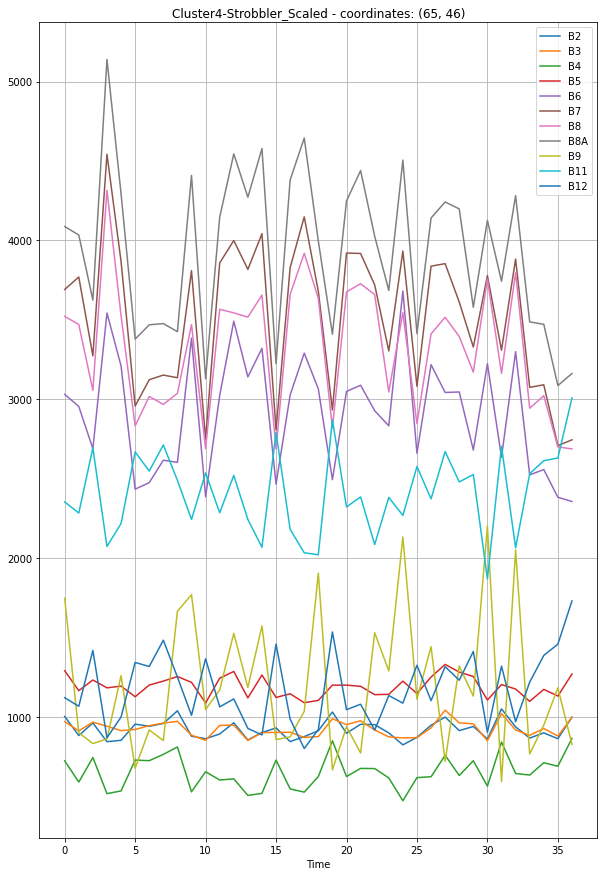

In [30]:
plt.figure(figsize=(10,15))
plt.plot(TRAINpredicted[:,1:-2]);
plt.xlabel('Time')
plt.title(f'{landcover} - coordinates: ({x}, {y})')
plt.grid()
plt.legend(bands[1:-2])
plt.savefig(f'{figures_filepath}/{landcover}_SCALEMETHODreflectancesRECONSTRUCTED.png', format='png', dpi=300)

# End